# Unsupervised Representation Learning by Predicting Image Rotations: CIFAR-10 + ```albumentations``` + PyTorch

[Unsupervised Representation Learning by Predicting Image Rotations](https://arxiv.org/abs/1803.07728) by Spyros Gidaris et al., [RotNet review](https://sh-tsang.medium.com/review-rotnet-unsupervised-representation-learning-by-predicting-image-rotations-60f4e4f3cf67)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import os, pickle

C:\Users\arjun\anaconda3\envs\torch-cuda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

torch version: 1.13.1
Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080 Laptop GPU


In [4]:
# print(torch.cuda.memory_summary())
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [5]:
# Specify training hyper-parameters-
batch_size = 256
num_epochs = 80

In [ ]:
"""
# Define torchvision transformations for training and test sets-
transform_train = transforms.Compose(
    [
        # transforms.RandomCrop(32, padding = 4),
        # transforms.RandomHorizontalFlip(p = 0.4),
        # transforms.RandomRotation(degrees = 40),
        # transforms.RandomVerticalFlip(p = 0.1),
        transforms.ColorJitter(brightness = 0, contrast = 0, saturation = 0, hue = 0),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)
"""

In [6]:
# Define transformations using albumentations-
transform_train = A.Compose(
    [
        # A.Resize(width = 32, height = 32),
        # A.RandomCrop(width = 20, height = 20),
        # A.Rotate(limit = 40, p = 0.9, border_mode = cv2.BORDER_CONSTANT),
        # A.HorizontalFlip(p = 0.5),
        # A.VerticalFlip(p = 0.1),
        A.RGBShift(r_shift_limit = 25, g_shift_limit = 25, b_shift_limit = 25, p = 0.9),
        A.OneOf([
            A.Blur(blur_limit = 3, p = 0.5),
            A.ColorJitter(p = 0.5),
        ], p = 1.0),
        A.Normalize(
            # mean = [0.4914, 0.4822, 0.4465],
            # std = [0.247, 0.243, 0.261],
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255,
        ),
        # This is not dividing by 255, which it does in PyTorch-
        ToTensorV2(),
    ]
)

transform_test = A.Compose(
    [
        A.Normalize(
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255
        ),
        ToTensorV2()
    ]
)

In [7]:
class Cifar10Dataset(torchvision.datasets.CIFAR10):
    def __init__(
        self, root = "~/data/cifar10",
        train = True, download = True,
        transform = None
    ):
        super().__init__(
            root = root, train = train,
            download = download, transform = transform
        )

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image = image)
            image = transformed["image"]
            
            # Randomly select 0, 1, 2 or 3 for image rotation-
            ang = np.random.randint(low = 0, high = 4, size = None)
            image = TF.rotate(img = image, angle = ang * 90)
            
        # return image, label
        return image, ang


In [8]:
# Define train and validate sets-
train_dataset = Cifar10Dataset(
    root = 'C:/Users/arjun/Downloads/data/', train = True,
    download = True, transform = transform_train
)

test_dataset = Cifar10Dataset(
    root = 'C:/Users/arjun/Downloads/data/', train = False,
    download = True, transform = transform_test
)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Create training and testing loaders-
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size,
    shuffle = True
)

In [ ]:
"""
x, y = next(iter(train_loader))

# For visualizations-

# Unnormalize images-
x = x / 2 + 0.5

# Transpose axes for visualization-
x = np.transpose(x.numpy(), (0, 2, 3, 1))

x.shape
# (256, 32, 32, 3)
"""

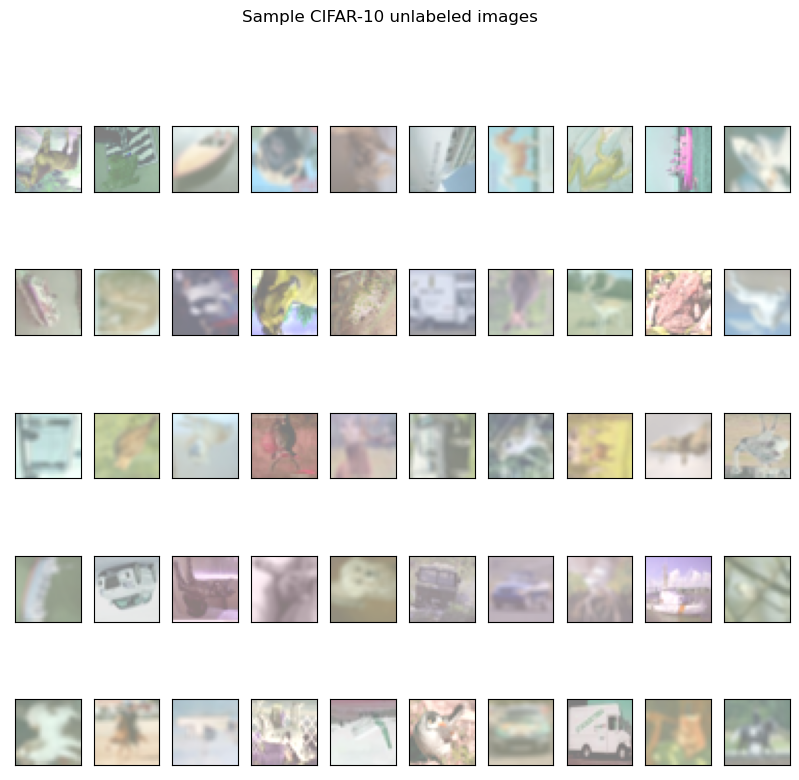

In [12]:
# Visualize 50 images from training set-
plt.figure(figsize = (10, 9))

for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(x[i])
    # get current axes-
    ax = plt.gca()

    # hide x-axis-
    ax.get_xaxis().set_visible(False)

    # hide y-axis-
    ax.get_yaxis().set_visible(False)
    
plt.suptitle("Sample CIFAR-10 unlabeled images")
plt.show()

In [ ]:
# del x, y

In [10]:
class ResNet_Block(nn.Module):
    '''
    ResNet block within a ResNet-18/34 CNN model
    '''
    def __init__(
        self, num_inp_channels,
        num_channels, stride = 1,
        dropout = 0.2, use_1x1_conv = False
    ):
        super(ResNet_Block, self).__init__()
        
        self.num_inp_channels = num_inp_channels
        self.num_channels = num_channels
        self.stride = stride
        self.dropout = dropout
        self.use_1x1_conv = use_1x1_conv
    
        
        self.conv1 = nn.Conv2d(
            in_channels = self.num_inp_channels, out_channels = self.num_channels,
            kernel_size = 3, padding = 1,
            stride = self.stride, bias = False
        )
        self.bn1 = nn.BatchNorm2d(num_features = self.num_channels)
        
        self.conv2 = nn.Conv2d(
            in_channels = self.num_channels, out_channels = self.num_channels,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn2 = nn.BatchNorm2d(num_features = self.num_channels)
        self.dropout = nn.Dropout(p = self.dropout)
        
        if self.use_1x1_conv:
            self.conv3 = nn.Conv2d(
            in_channels = self.num_inp_channels, out_channels = num_channels,
            kernel_size = 1, padding = 0,
            stride = self.stride, bias = False
            )
            self.bn3 = nn.BatchNorm2d(num_features = self.num_channels)
        
        self.initialize_weights()

            
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)

                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        y = F.leaky_relu(self.bn1(self.conv1(x)))
        y = self.dropout(F.leaky_relu(self.bn2(self.conv2(y))))
        
        if self.use_1x1_conv:
            x = self.bn3(self.conv3(x))
            
        y += x
        return F.leaky_relu(self.dropout(y))
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        y = (self.bn1(self.conv1(x)))
        print(f"First conv layer output shape: {y.shape}")
        y = self.bn2(self.conv2(y))
        print(f"Second conv layer output shape: {y.shape}")
        
        if self.use_1x1_conv:
            x = self.bn3(self.conv3(x))
            print(f"Downsample with S = 2; identity connection output shape: {x.shape}")
            
        y += x
        print(f"Residual block output shape: {y.shape}")
        return None
    

In [11]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = 3, out_channels = 64,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn1 = nn.BatchNorm2d(num_features = 64)
        
        self.resblock1 = ResNet_Block(
            num_inp_channels = 64, num_channels = 64,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        self.resblock2 = ResNet_Block(
            num_inp_channels = 64, num_channels = 64,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        # Downsample-
        self.resblock3 = ResNet_Block(
            num_inp_channels = 64, num_channels = 128,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )
        
        self.resblock4 = ResNet_Block(
            num_inp_channels = 128, num_channels = 128,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        # Downsample-
        self.resblock5 = ResNet_Block(
            num_inp_channels = 128, num_channels = 256,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )

        self.resblock6 = ResNet_Block(
            num_inp_channels = 256, num_channels = 256,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        # Downsample-
        self.resblock7 = ResNet_Block(
            num_inp_channels = 256, num_channels = 512,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )

        self.resblock8 = ResNet_Block(
            num_inp_channels = 512, num_channels = 512,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        self.avg_pool = nn.AvgPool2d(kernel_size = 3, stride = 2)
        self.op_layer = nn.Linear(
            in_features = 512, out_features = 4,
            bias = True
        )
        
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)
        x = self.resblock6(x)
        x = self.resblock7(x)
        x = self.resblock8(x)
        x = self.avg_pool(x).squeeze()
        x = self.op_layer(x)
        return x
    

In [12]:
# Initialize ResNet-18 architecture-
model = ResNet18().to(device)

In [13]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

print(f"Total number of trainable parameters in ResNet-18 CNN = {tot_params}")

Total number of trainable parameters in ResNet-18 CNN = 11170884


In [14]:
# Save random initial weights-
# torch.save(model.state_dict(), 'ResNet18_CIFAR10_RotNet-Random_Weights.pth')

# Load randomly initialised weights-
model.load_state_dict(torch.load('ResNet18_CIFAR10_RotNet-Random_Weights.pth'))

<All keys matched successfully>

In [15]:
# Define loss function and optimizer-
cost_fn = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9, weight_decay = 5e-4)

#### MultiStepLR PyTorch

```
torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1, last_epoch=- 1, verbose=False)
```

Decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones. Notice that such decay can happen simultaneously with other changes to the learning rate from outside this scheduler. When last_epoch=-1, sets initial lr as lr.

Parameters:

- optimizer (Optimizer) – Wrapped optimizer.
- milestones (list) – List of epoch indices. Must be increasing.
- gamma (float) – Multiplicative factor of learning rate decay. Default: 0.1.
- last_epoch (int) – The index of last epoch. Default: -1.
- verbose (bool) – If True, prints a message to stdout for each update. Default: False.

Example:

```
# Assuming optimizer uses lr = 0.05 for all groups
# lr = 0.05     if epoch < 30
# lr = 0.005    if 30 <= epoch < 80
# lr = 0.0005   if epoch >= 80
scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
```

[MultiStepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html). You might aso consider [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html) scheduler.


In [16]:
# Decay lr at 20th, 50th & 68th epochs by a factor of 10-
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer = optimizer, milestones = [20, 50, 68],
    gamma = 0.1
)

In [17]:
def train_model_progress(model, train_loader, train_dataset):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            # J = loss(outputs, labels)
            J = cost_fn(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # global step
            # optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)

            # step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()


In [18]:
def test_model_progress(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = cost_fn(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [19]:
# Python3 dict to contain training metrics-
training_history = {}

# Initialize parameters saving 'best' models-
best_val_acc = 80

In [20]:
for epoch in range(1, num_epochs + 1):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    
    val_loss, val_acc = test_model_progress(
        model = model, test_loader = test_loader,
        test_dataset = test_loader
    )
    
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]
    
    print(f"Epoch: {epoch}; loss = {train_loss:.4f}, acc = {train_acc:.2f}%",
          f" val loss = {val_loss:.4f}, val acc = {val_acc:.2f}% & LR = {current_lr:.5f}"
         )
    
    # Save training metrics to Python3 dict-
    training_history[epoch] = {
        'train_loss': train_loss, 'val_loss': val_loss,
        'train_acc': train_acc, 'val_acc': val_acc,
        'lr': current_lr
    }

    # Save best weights achieved until now-
    if (val_acc > best_val_acc):    
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val_acc = {val_acc:.2f}%\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "ResNet18_CIFAR10_RotNet_best_acc.pth")
        

Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.12batch/s, val_acc=27.7, val_loss=343]


Epoch: 1; loss = 1.8371, acc = 27.49%  val loss = 342.8571, val acc = 27.70% & LR = 0.10000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.21batch/s, val_acc=28.1, val_loss=342]


Epoch: 2; loss = 1.3435, acc = 32.17%  val loss = 342.4329, val acc = 28.06% & LR = 0.10000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.11batch/s, val_acc=45.3, val_loss=293]


Epoch: 3; loss = 1.2623, acc = 39.09%  val loss = 293.2949, val acc = 45.29% & LR = 0.10000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.37batch/s, val_acc=49.9, val_loss=279]


Epoch: 4; loss = 1.1761, acc = 46.37%  val loss = 279.1081, val acc = 49.92% & LR = 0.10000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.52batch/s, val_acc=50.8, val_loss=271]


Epoch: 5; loss = 1.1323, acc = 49.35%  val loss = 271.3943, val acc = 50.81% & LR = 0.10000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.40batch/s, val_acc=54.7, val_loss=259]


Epoch: 6; loss = 1.1001, acc = 51.57%  val loss = 259.3478, val acc = 54.66% & LR = 0.10000


Validation: : 100%|███████████████████████████████████████| 40/40 [00:04<00:00,  9.38batch/s, val_acc=55, val_loss=258]


Epoch: 7; loss = 1.0835, acc = 52.62%  val loss = 257.6431, val acc = 55.02% & LR = 0.10000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  8.83batch/s, val_acc=55.3, val_loss=257]


Epoch: 8; loss = 1.0670, acc = 53.70%  val loss = 256.8606, val acc = 55.29% & LR = 0.10000


Validation: : 100%|███████████████████████████████████████| 40/40 [00:04<00:00,  9.39batch/s, val_acc=57, val_loss=252]


Epoch: 9; loss = 1.0497, acc = 54.64%  val loss = 251.6212, val acc = 56.96% & LR = 0.10000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.36batch/s, val_acc=57.5, val_loss=250]


Epoch: 10; loss = 1.0363, acc = 55.41%  val loss = 249.8080, val acc = 57.49% & LR = 0.10000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.50batch/s, val_acc=58.6, val_loss=242]


Epoch: 11; loss = 1.0165, acc = 56.48%  val loss = 242.3031, val acc = 58.56% & LR = 0.10000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.31batch/s, val_acc=60.6, val_loss=232]


Epoch: 12; loss = 0.9966, acc = 57.69%  val loss = 232.4758, val acc = 60.55% & LR = 0.10000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.47batch/s, val_acc=60.6, val_loss=240]


Epoch: 13; loss = 0.9756, acc = 59.01%  val loss = 239.5165, val acc = 60.55% & LR = 0.10000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=60.7, val_loss=234]


Epoch: 14; loss = 0.9583, acc = 59.92%  val loss = 233.7226, val acc = 60.66% & LR = 0.10000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.32batch/s, val_acc=61.5, val_loss=231]


Epoch: 15; loss = 0.9457, acc = 60.50%  val loss = 231.2293, val acc = 61.52% & LR = 0.10000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.44batch/s, val_acc=63.6, val_loss=222]


Epoch: 16; loss = 0.9239, acc = 61.57%  val loss = 221.9196, val acc = 63.64% & LR = 0.10000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.41batch/s, val_acc=60.6, val_loss=240]


Epoch: 17; loss = 0.9115, acc = 62.35%  val loss = 240.2400, val acc = 60.57% & LR = 0.10000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.43batch/s, val_acc=62.8, val_loss=223]


Epoch: 18; loss = 0.8973, acc = 63.12%  val loss = 222.9921, val acc = 62.77% & LR = 0.10000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.48batch/s, val_acc=62.8, val_loss=228]


Epoch: 19; loss = 0.8857, acc = 63.57%  val loss = 227.5027, val acc = 62.76% & LR = 0.10000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.46batch/s, val_acc=65.5, val_loss=213]


Epoch: 20; loss = 0.8694, acc = 64.46%  val loss = 212.7435, val acc = 65.47% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.44batch/s, val_acc=70.7, val_loss=184]


Epoch: 21; loss = 0.8037, acc = 67.43%  val loss = 184.1302, val acc = 70.71% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.46batch/s, val_acc=71.3, val_loss=180]


Epoch: 22; loss = 0.7725, acc = 68.99%  val loss = 179.6064, val acc = 71.26% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.50batch/s, val_acc=72.1, val_loss=173]


Epoch: 23; loss = 0.7557, acc = 69.62%  val loss = 172.8476, val acc = 72.06% & LR = 0.01000


Validation: : 100%|███████████████████████████████████████| 40/40 [00:04<00:00,  9.03batch/s, val_acc=72, val_loss=174]


Epoch: 24; loss = 0.7458, acc = 70.31%  val loss = 173.8659, val acc = 71.95% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.06batch/s, val_acc=72.3, val_loss=174]


Epoch: 25; loss = 0.7318, acc = 70.65%  val loss = 173.5606, val acc = 72.30% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.01batch/s, val_acc=73.3, val_loss=169]


Epoch: 26; loss = 0.7234, acc = 71.02%  val loss = 168.6376, val acc = 73.30% & LR = 0.01000


Validation: : 100%|███████████████████████████████████████| 40/40 [00:04<00:00,  9.13batch/s, val_acc=74, val_loss=166]


Epoch: 27; loss = 0.7123, acc = 71.53%  val loss = 166.3099, val acc = 74.00% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.03batch/s, val_acc=73.7, val_loss=163]


Epoch: 28; loss = 0.6981, acc = 72.17%  val loss = 163.4044, val acc = 73.67% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.19batch/s, val_acc=72.9, val_loss=175]


Epoch: 29; loss = 0.6870, acc = 72.48%  val loss = 174.9741, val acc = 72.93% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.22batch/s, val_acc=75.1, val_loss=158]


Epoch: 30; loss = 0.6694, acc = 73.44%  val loss = 157.5469, val acc = 75.07% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  8.97batch/s, val_acc=75.1, val_loss=155]


Epoch: 31; loss = 0.6639, acc = 73.48%  val loss = 155.2050, val acc = 75.10% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.05batch/s, val_acc=76.2, val_loss=150]


Epoch: 32; loss = 0.6490, acc = 74.38%  val loss = 150.4831, val acc = 76.19% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.20batch/s, val_acc=76.4, val_loss=152]


Epoch: 33; loss = 0.6392, acc = 74.79%  val loss = 151.5999, val acc = 76.44% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.31batch/s, val_acc=76.6, val_loss=147]


Epoch: 34; loss = 0.6290, acc = 75.23%  val loss = 146.6757, val acc = 76.63% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.33batch/s, val_acc=77.4, val_loss=144]


Epoch: 35; loss = 0.6193, acc = 75.46%  val loss = 143.9761, val acc = 77.42% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.42batch/s, val_acc=77.4, val_loss=144]


Epoch: 36; loss = 0.6072, acc = 75.90%  val loss = 143.8995, val acc = 77.38% & LR = 0.01000


Validation: : 100%|███████████████████████████████████████| 40/40 [00:04<00:00,  9.22batch/s, val_acc=78, val_loss=141]


Epoch: 37; loss = 0.5975, acc = 76.50%  val loss = 141.1617, val acc = 77.95% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.22batch/s, val_acc=77.4, val_loss=143]


Epoch: 38; loss = 0.5894, acc = 76.89%  val loss = 143.1008, val acc = 77.43% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.10batch/s, val_acc=78.8, val_loss=138]


Epoch: 39; loss = 0.5806, acc = 77.27%  val loss = 137.5374, val acc = 78.75% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.45batch/s, val_acc=79.1, val_loss=135]


Epoch: 40; loss = 0.5693, acc = 77.69%  val loss = 135.0287, val acc = 79.08% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.51batch/s, val_acc=78.7, val_loss=140]


Epoch: 41; loss = 0.5632, acc = 78.06%  val loss = 139.9088, val acc = 78.68% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.47batch/s, val_acc=78.8, val_loss=140]


Epoch: 42; loss = 0.5563, acc = 78.33%  val loss = 140.0763, val acc = 78.82% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.42batch/s, val_acc=79.3, val_loss=134]


Epoch: 43; loss = 0.5445, acc = 78.69%  val loss = 133.6938, val acc = 79.35% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.35batch/s, val_acc=80.5, val_loss=127]


Epoch: 44; loss = 0.5409, acc = 78.99%  val loss = 126.8910, val acc = 80.46% & LR = 0.01000
Saving model with highest val_acc = 80.46%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.37batch/s, val_acc=81.2, val_loss=124]


Epoch: 45; loss = 0.5297, acc = 79.50%  val loss = 124.2160, val acc = 81.17% & LR = 0.01000
Saving model with highest val_acc = 81.17%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.37batch/s, val_acc=80.3, val_loss=125]


Epoch: 46; loss = 0.5211, acc = 79.66%  val loss = 125.2959, val acc = 80.34% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.43batch/s, val_acc=81.3, val_loss=121]


Epoch: 47; loss = 0.5175, acc = 79.91%  val loss = 120.8879, val acc = 81.31% & LR = 0.01000
Saving model with highest val_acc = 81.31%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.37batch/s, val_acc=80.2, val_loss=126]


Epoch: 48; loss = 0.5086, acc = 80.36%  val loss = 125.7844, val acc = 80.17% & LR = 0.01000


Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.41batch/s, val_acc=82.4, val_loss=115]


Epoch: 49; loss = 0.5007, acc = 80.93%  val loss = 115.4937, val acc = 82.44% & LR = 0.01000
Saving model with highest val_acc = 82.44%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.24batch/s, val_acc=81.3, val_loss=120]


Epoch: 50; loss = 0.4901, acc = 81.29%  val loss = 119.8400, val acc = 81.33% & LR = 0.00100


Validation: : 100%|███████████████████████████████████████| 40/40 [00:04<00:00,  9.38batch/s, val_acc=84, val_loss=104]


Epoch: 51; loss = 0.4498, acc = 82.83%  val loss = 104.2729, val acc = 84.02% & LR = 0.00100
Saving model with highest val_acc = 84.02%



Validation: : 100%|███████████████████████████████████████| 40/40 [00:04<00:00,  9.36batch/s, val_acc=84, val_loss=104]


Epoch: 52; loss = 0.4321, acc = 83.49%  val loss = 103.5992, val acc = 84.04% & LR = 0.00100
Saving model with highest val_acc = 84.04%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.39batch/s, val_acc=84.1, val_loss=104]


Epoch: 53; loss = 0.4274, acc = 83.66%  val loss = 104.1953, val acc = 84.09% & LR = 0.00100
Saving model with highest val_acc = 84.09%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  9.38batch/s, val_acc=84.6, val_loss=101]


Epoch: 54; loss = 0.4240, acc = 83.78%  val loss = 101.3066, val acc = 84.58% & LR = 0.00100
Saving model with highest val_acc = 84.58%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  8.92batch/s, val_acc=84.8, val_loss=101]


Epoch: 55; loss = 0.4183, acc = 84.20%  val loss = 100.7340, val acc = 84.79% & LR = 0.00100
Saving model with highest val_acc = 84.79%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  8.95batch/s, val_acc=84.7, val_loss=100]


Epoch: 56; loss = 0.4166, acc = 84.11%  val loss = 100.4506, val acc = 84.73% & LR = 0.00100


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  9.02batch/s, val_acc=85, val_loss=99.2]


Epoch: 57; loss = 0.4119, acc = 84.39%  val loss = 99.2179, val acc = 84.99% & LR = 0.00100
Saving model with highest val_acc = 84.99%



Validation: : 100%|█████████████████████████████████████| 40/40 [00:04<00:00,  8.96batch/s, val_acc=84.8, val_loss=100]


Epoch: 58; loss = 0.4127, acc = 84.35%  val loss = 99.9685, val acc = 84.80% & LR = 0.00100


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.00batch/s, val_acc=84.9, val_loss=99.5]


Epoch: 59; loss = 0.4065, acc = 84.62%  val loss = 99.4862, val acc = 84.91% & LR = 0.00100


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.92batch/s, val_acc=84.7, val_loss=98.8]


Epoch: 60; loss = 0.4064, acc = 84.51%  val loss = 98.7927, val acc = 84.73% & LR = 0.00100


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.09batch/s, val_acc=85.2, val_loss=97.6]


Epoch: 61; loss = 0.4002, acc = 84.76%  val loss = 97.5603, val acc = 85.23% & LR = 0.00100
Saving model with highest val_acc = 85.23%



Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.16batch/s, val_acc=85.4, val_loss=96.5]


Epoch: 62; loss = 0.3983, acc = 84.86%  val loss = 96.4814, val acc = 85.36% & LR = 0.00100
Saving model with highest val_acc = 85.36%



Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.86batch/s, val_acc=85.2, val_loss=96.9]


Epoch: 63; loss = 0.3960, acc = 85.01%  val loss = 96.9304, val acc = 85.20% & LR = 0.00100


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.86batch/s, val_acc=85.3, val_loss=96.9]


Epoch: 64; loss = 0.3906, acc = 85.26%  val loss = 96.8772, val acc = 85.31% & LR = 0.00100


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.07batch/s, val_acc=85.2, val_loss=96.2]


Epoch: 65; loss = 0.3925, acc = 85.20%  val loss = 96.2477, val acc = 85.23% & LR = 0.00100


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.08batch/s, val_acc=85.6, val_loss=95.6]


Epoch: 66; loss = 0.3893, acc = 85.19%  val loss = 95.6463, val acc = 85.61% & LR = 0.00100
Saving model with highest val_acc = 85.61%



Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.07batch/s, val_acc=85.8, val_loss=94.3]


Epoch: 67; loss = 0.3832, acc = 85.49%  val loss = 94.3333, val acc = 85.79% & LR = 0.00100
Saving model with highest val_acc = 85.79%



Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.04batch/s, val_acc=85.3, val_loss=95.5]


Epoch: 68; loss = 0.3853, acc = 85.33%  val loss = 95.4516, val acc = 85.31% & LR = 0.00010


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  9.17batch/s, val_acc=85.7, val_loss=94]


Epoch: 69; loss = 0.3788, acc = 85.67%  val loss = 94.0215, val acc = 85.73% & LR = 0.00010


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.98batch/s, val_acc=85.5, val_loss=95.4]


Epoch: 70; loss = 0.3771, acc = 85.80%  val loss = 95.3886, val acc = 85.45% & LR = 0.00010


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  9.09batch/s, val_acc=85.7, val_loss=94.5]


Epoch: 71; loss = 0.3755, acc = 85.70%  val loss = 94.4623, val acc = 85.70% & LR = 0.00010


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.47batch/s, val_acc=85.7, val_loss=94.9]


Epoch: 72; loss = 0.3789, acc = 85.66%  val loss = 94.8807, val acc = 85.67% & LR = 0.00010


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.42batch/s, val_acc=85.6, val_loss=94.7]


Epoch: 73; loss = 0.3744, acc = 85.83%  val loss = 94.7165, val acc = 85.64% & LR = 0.00010


Validation: : 100%|████████████████████████████████████| 40/40 [00:05<00:00,  7.87batch/s, val_acc=85.5, val_loss=94.3]


Epoch: 74; loss = 0.3743, acc = 85.77%  val loss = 94.2605, val acc = 85.50% & LR = 0.00010


Validation: : 100%|██████████████████████████████████████| 40/40 [00:05<00:00,  7.81batch/s, val_acc=86, val_loss=93.3]


Epoch: 75; loss = 0.3720, acc = 85.89%  val loss = 93.2894, val acc = 85.96% & LR = 0.00010
Saving model with highest val_acc = 85.96%



Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.16batch/s, val_acc=85.9, val_loss=94.4]


Epoch: 76; loss = 0.3722, acc = 86.03%  val loss = 94.4036, val acc = 85.89% & LR = 0.00010


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.11batch/s, val_acc=85.7, val_loss=94.8]


Epoch: 77; loss = 0.3711, acc = 85.99%  val loss = 94.8014, val acc = 85.74% & LR = 0.00010


Validation: : 100%|████████████████████████████████████| 40/40 [00:04<00:00,  8.00batch/s, val_acc=85.8, val_loss=92.8]


Epoch: 78; loss = 0.3719, acc = 85.96%  val loss = 92.7581, val acc = 85.76% & LR = 0.00010


Validation: : 100%|████████████████████████████████████| 40/40 [00:05<00:00,  7.90batch/s, val_acc=85.5, val_loss=94.1]


Epoch: 79; loss = 0.3720, acc = 85.69%  val loss = 94.0771, val acc = 85.54% & LR = 0.00010


Validation: : 100%|██████████████████████████████████████| 40/40 [00:04<00:00,  8.06batch/s, val_acc=85.8, val_loss=94]

Epoch: 80; loss = 0.3696, acc = 86.08%  val loss = 94.0321, val acc = 85.77% & LR = 0.00010


In [21]:
# Save training metrics as pickled object-
with open("ResNet18_CIFAR10_RotNet_training_history.pkl", "wb") as file:
    pickle.dump(training_history, file)

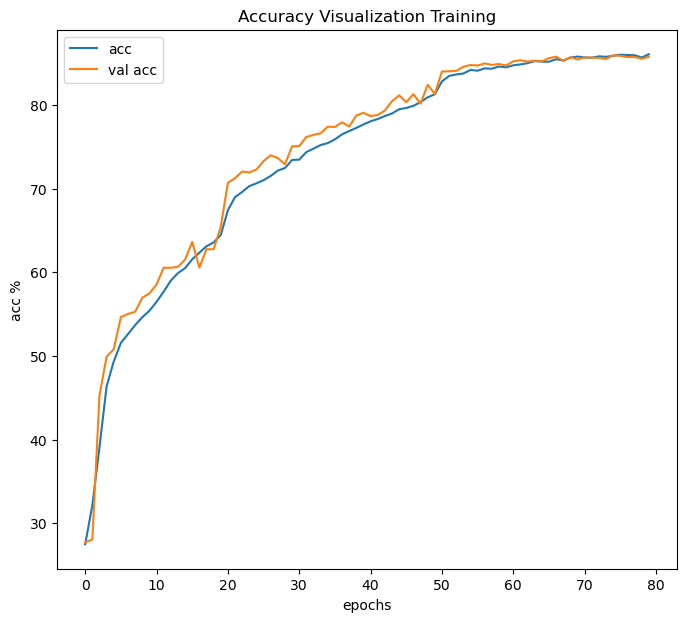

In [22]:
plt.figure(figsize = (8, 7))
plt.plot([training_history[e]['train_acc'] for e in training_history.keys()], label = 'acc')
plt.plot([training_history[e]['val_acc'] for e in training_history.keys()], label = 'val acc')
plt.xlabel("epochs")
plt.ylabel("acc %")
plt.title("Accuracy Visualization Training")
plt.legend(loc = 'best')
plt.show()

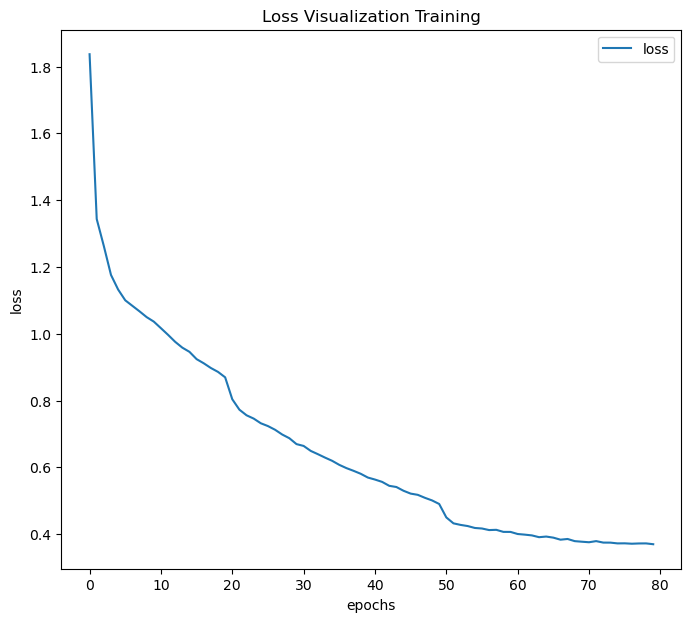

In [24]:
plt.figure(figsize = (8, 7))
plt.plot([training_history[e]['train_loss'] for e in training_history.keys()], label = 'loss')
# plt.plot([training_history[e]['val_loss'] for e in training_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss Visualization Training")
plt.legend(loc = 'best')
plt.show()

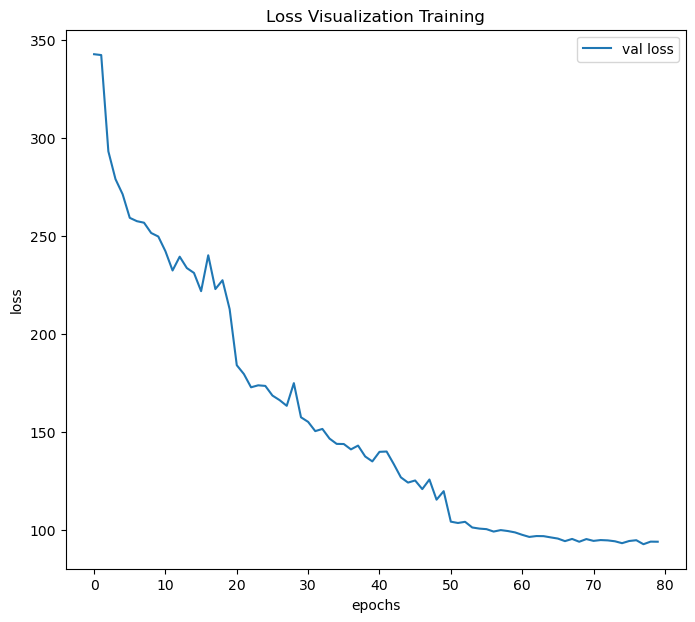

In [25]:
plt.figure(figsize = (8, 7))
# plt.plot([training_history[e]['train_loss'] for e in training_history.keys()], label = 'loss')
plt.plot([training_history[e]['val_loss'] for e in training_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss Visualization Training")
plt.legend(loc = 'best')
plt.show()

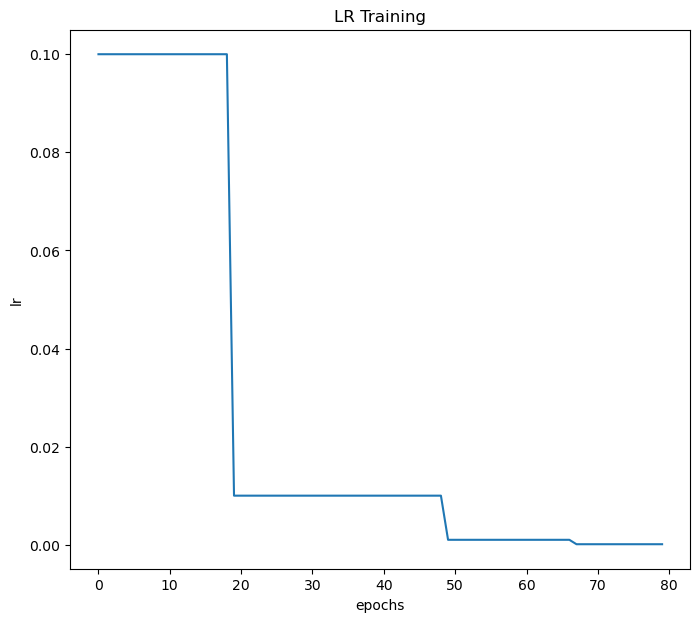

In [26]:
plt.figure(figsize = (8, 7))
plt.plot([training_history[e]['lr'] for e in training_history.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("LR Training")
plt.show()